In [1]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
from torchvision.transforms import v2
# from Moduls.MosreDataset import MosreDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.parallel import DataParallel
from collections import Counter

DEVICE = torch.device("cuda")

MAIN = pt(os.getcwd())
DATASET_PATCH = MAIN / 'morse_dataset'
AUDIO_FILES = DATASET_PATCH / 'morse_dataset'

# Поятоянные значения выявленные в процессе анализа
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 128
N_FFT = 400
HOP_LENGTH = 180
TOP_DB = 80
FREQ_MASK = 30
TIME_MASK = 40

# Гиперпараметы обучения
SEED = 42
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.002 
WEIGHT_DECAY = 0.00001

#===== Import data =====
train_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'sample_submission.csv'))

all_chars = Counter("".join(train_data['message']))
BLANK_CHAR = "_"
vocab_list = sorted(all_chars.keys()) + [BLANK_CHAR]
num_classes = len(vocab_list)
char_to_int = {char: i for i, char in enumerate(vocab_list)}
int_to_char = {i: char for i, char in enumerate(vocab_list)}
BLANK_IDX = char_to_int[BLANK_CHAR]

class MosreDataset(Dataset):
    """
    Класс для обработки 
    """
    def __init__(self, df, data_patch,char_to_int, train=True, transforms=None, prev_chars = 1):
        self.df = df
        self.is_train = train

        self.data_path = data_patch
        self.audio_paths = self.data_path / 'morse_dataset'

        self.transforms = transforms

        self.char_to_int = char_to_int
        self.prev_chars = prev_chars

        if self.is_train:
            self.messeges = self.df.message.values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #Получение аугментрованых спектрограмм
        try:
            audio_file = self.audio_paths / self.df.id.values[index]
            waveform, sample_rate = torchaudio.load(audio_file)
            augmented_spectrogram = self.transforms(waveform)

            if self.is_train:
                message = self.messeges[index]
                #Получение списка индексов секта - как требует CTC los
                '''
                При обработке dataloader labels будут выравниваться по макс длине для выравнивания батча
                Т.е. будет padding 0. что в будующем будет пустым значением для ctc loss
                '''
                target = torch.tensor([self.char_to_int[char] for char in message], dtype=torch.long); 
                target_len = torch.tensor(len(target), dtype=torch.long)
                return augmented_spectrogram, target, target_len, message
            else:
                return augmented_spectrogram, None, None, None
        except Exception as ex:
            print(str(ex))
        
    def change_time(self, audio_file, max_len = 384000):
        waveform, sample_rate = torchaudio.load(audio_file)
        cahanal, sig_len = waveform.shape

        if sig_len < max_len:
            pad_len = torch.zeros(max_len - sig_len).unsqueeze(0)
            waveform = torch.cat([waveform, pad_len], dim=1)

        return waveform
    
FIRST_FE_COUNT = 16
SECOND_FE_COUNT = 32
THIRD_FE_COUNT = 32
QAD_FE_COUNT = 32
PADDING = 'same'
MAXPOOL_KERNEL = 2
KERTNEL_SIZE = 3
NERON_COUNT = 128
GRU_HIDEN = 512
# Start with 4 transforms
class MorseNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=FIRST_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(FIRST_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((1, 2), (1, 2)), # [batch, FIRST_FE_COUNT = 16, 64, 960]

            nn.Conv2d(in_channels=FIRST_FE_COUNT, 
                      out_channels=SECOND_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(SECOND_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)), # [batch, SECOND_FE_COUNT = 32, 32, 480]

            nn.Conv2d(in_channels=SECOND_FE_COUNT, 
                      out_channels=THIRD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(THIRD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 2), (2, 2)), # [batch, THIRD_FE_COUNT = 32, 16, 240]

            nn.Conv2d(in_channels=THIRD_FE_COUNT, 
                      out_channels=QAD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(QAD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)) # [batch=32, QAD_FE_COUNT = 32, 8, 80](что юы сохраниить большще признаков по горизонтали)
        )
        with torch.no_grad(): 
            dummy_input = torch.randn(1, 1, N_MELS, 356); 
            cnn_out = self.net_conv(dummy_input); 
            self.cnn_output_features = cnn_out.shape[1] * cnn_out.shape[2]

        print(f"CNN размерность выхода: {cnn_out.shape}"); 
        print(f"CNN число фичей: {self.cnn_output_features}")

        # Добавлен лоейный слой и функция активации. Для чего? расписать потом 
        self.layer1 = nn.Linear(self.cnn_output_features, N_MELS*2); 
        self.gelu = nn.GELU()
        print(f"Проекция из {self.cnn_output_features} в {GRU_HIDEN*2}")
        self.rnn = nn.GRU(
                input_size=N_MELS*2,
                hidden_size=GRU_HIDEN,
                num_layers=3,
                bidirectional=True,
                batch_first=True,
            )

        
        self.embed_dim = GRU_HIDEN * 2

        self.layer_norm = nn.LayerNorm(self.embed_dim)   
        # self.dropout = nn.Dropout(0.3)   
        self.layer2 = nn.Linear(self.embed_dim, num_classes)       
        

    def forward(self, x):
        x = self.net_conv(x)

        batch, channels, reduced_mels, reduced_time = x.shape
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, mels]

        # В частности, каждый вектор признаков в последовательности признаков генерируется 
        # слева направо на картах признаков. Это означает, что i-й вектор признаков представляет 
        # собой объединение столбцов всех карт. 
        # Таким образом, форма тензора может быть изменена, например, на (размер_пакета, 80, 256)
        
        x = x.reshape(batch, reduced_time, -1)  # to GRU [batch=32, seq_len=89, features/hiden_dim=512]
        x = self.layer1(x)
        x = self.gelu(x)

        self.rnn.flatten_parameters()

        x = self.rnn(x) # [batch=32, seq_len=89, features/hiden_dim=256 * 2]
        x, _ = x # берем информацию со всез состояний
        x = self.layer_norm(x)
        # x = self.dropout(x)
        x = self.layer2(x) # logits - [batch, sequence, num_classes] 
        x = nn.functional.log_softmax(x.permute(1,0,2), dim=2) # pertime так как CTC loss требует на взод (sequence/T,batch/N,num_classes/C)
        '''
        по одному прогнозу для каждого из признаков в последовательности, 
        в итоге получается 89 прогнозов символов для каждой секунды звука.
        '''
        return x
    

train_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    transforms.FrequencyMasking(freq_mask_param=FREQ_MASK),
    transforms.TimeMasking(time_mask_param=TIME_MASK),
    ) 
# заметка - Данные трансформации не создают довых обучаемых параметров. Но есть и те что создают. В будущем это стоит учитывать

valid_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),

    )

train_dataframe, val_dataframe = train_test_split(train_data, test_size=0.15, random_state=SEED)

train_ds = MosreDataset(df=train_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=train_audio_transforms)

val_ds = MosreDataset(df=val_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=valid_audio_transforms)

def my_collate(batch):
    spectrograms = [item[0].squeeze(0) for item in batch]
    # Падинг спектрограмм по максимальной длине
    spectrograms_permuted = [s.permute(1, 0) for s in spectrograms]
    spectrograms_padded = nn.utils.rnn.pad_sequence(spectrograms_permuted, batch_first=True, padding_value=0.0)
    spectrograms_padded = spectrograms_padded.permute(0, 2, 1).unsqueeze(1)

    if batch[0][3] is not None:
        target = torch.nn.utils.rnn.pad_sequence(
                                                [item[1] for item in batch], 
                                                batch_first=True, 
                                                padding_value=BLANK_IDX)# выравнивает последовательность до макс 
                                                                        # длины в батче заполняя пропуски нулем
        label_len = torch.stack([item[2] for item in batch])
        msg = [item[3] for item in batch]
        
        return [spectrograms_padded, target, label_len, msg]
    else: 
        return spectrograms_padded


train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate, drop_last=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate, drop_last=True)



#===== начало обучения =====
model = MorseNet(num_classes=num_classes).to(DEVICE)
model = DataParallel(model)
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=6)
loss_func = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nMorseNet - инициалицация модели. Число обучаемых параметров: {total_params:,}")

CNN размерность выхода: torch.Size([1, 32, 16, 89])
CNN число фичей: 512
Проекция из 512 в 1024

MorseNet - инициалицация модели. Число обучаемых параметров: 12,017,933


In [3]:
# a= model(test)
# a.shape, a

Подсказка по ctc loss

In [5]:
# Target are to be un-padded
T = 50      # Input sequence length
C = 20      # Number of classes (including blank)
N = 16      # Batch size
# Initialize random batch of input vectors, for *size = (T,N,C)
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()
input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
# Initialize random batch of targets (0 = blank, 1:C = classes)
target_lengths = torch.randint(low=1, high=T, size=(N,), dtype=torch.long)
target = torch.randint(low=1, high=C, size=(sum(target_lengths),), dtype=torch.long)
ctc_loss = nn.CTCLoss()
loss = ctc_loss(input, target, input_lengths, target_lengths)
loss.backward()
# input.detach().numpy().shape
loss.grad

C:\Users\homer\AppData\Local\Temp\ipykernel_20744\2733710114.py:15: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  loss.grad


In [ ]:
lst_loss_train = []
lst_loss_val = []
pr = []
p_Val = []
for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0
    pr = []

    train_tqdm = tqdm(train_dl, desc=f"Эпоха {epoch+1}/{EPOCHS} [Обучение]", leave=False)
    for batch_ind, batch in enumerate(train_tqdm):
        mel_spec, targets, targets_lens, _ = batch
        mel_spec, targets, targets_lens = mel_spec.to(DIVICE), targets.to(DIVICE), targets_lens.to(DIVICE)

        #===== считатем длинну mel_spec для передачи в CTC loss =====
        
        optimizer.zero_grad()
        predict = model(mel_spec) # (N=batch,T,C)
        pr.append(predict)

        N = predict.shape[1]
        T = predict.shape[0]
        predict_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

    #     print("Predict shape:", predict.shape) # [T, N, C]
    #     print("Labels shape:", targets.shape)   # [N, max_label_len]
    #     print("Predict lengths:", predict_lengths) # [N]
    #     print("Target lengths:", targets_lens.reshape(BATCH_SIZE))   # [N]
    #     break
    # break
        try:
            loss = loss_func(predict, targets, predict_lengths, targets_lens.reshape(BATCH_SIZE))
        except RuntimeError:
            print(predict.shape, targets.shape, predict_lengths, targets_lens.reshape(BATCH_SIZE))
            continue
        # print(loss)
        if torch.isnan(loss) or torch.isinf(loss): 
            print(f"\nWarning: In batch-{batch_ind} loss train is NaN/Inf: {loss.item()}"); 
            optimizer.zero_grad(); 
            continue

        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_train_loss += loss.item()
        train_loss = epoch_train_loss / len(train_dl)

    # ======== Валидация ========
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for val_mel_spec, val_labels, val_label_lensin, _ in tqdm(
                                                        val_dl, 
                                                        desc=f"Эпоха {epoch+1}/{EPOCHS} [Валидация]", 
                                                        leave=False):
            val_mel_spec, val_labels, val_label_lensin = val_mel_spec.to(DIVICE), val_labels.to(DIVICE), val_label_lensin.to(DIVICE)
            val_predict = model(val_mel_spec)

            p_Val.append(val_predict)
            val_N = val_predict.shape[1]
            val_T = val_predict.shape[0]
            predict_val_lengths = torch.full(size=(val_N,), fill_value=val_T, dtype=torch.long)
            epoch_val_loss += loss_func(val_predict, val_labels, predict_val_lengths, val_label_lensin).item()
            val_loss = epoch_val_loss / len(val_dl)

    lst_loss_train.append(train_loss)
    lst_loss_val.append(val_loss)

    # scheduler.step(val_loss)


            
    print(f"===== Эпоха {epoch+1}/{EPOCHS} =====")
    # print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    grad_norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
    if grad_norms:
        print(f"Mean grad norm: {np.mean(grad_norms):.6f}")
        print(f"Max grad norm: {np.max(grad_norms):.6f}")
        print(f"Min grad norm: {np.min(grad_norms):.6f}")
    else:
        print("No gradients computed yet.")

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"LR: {optimizer.param_groups[0]["lr"]:.2e}")
    print("\n"+"-" * 50)

# Обучение модели

In [ ]:
lst_loss_train = []
lst_loss_val = []
pr = []
p_Val = []

for epoch in range(EPOCHS):
    # ======== Обучение ========
    model.train()
    epoch_train_loss = 0.0
    
    train_tqdm = tqdm(train_dl, desc=f"Эпоха {epoch+1}/{EPOCHS} [Обучение]", leave=False)
    for batch_ind, batch in enumerate(train_tqdm):
        mel_spec, targets, targets_lens, _ = batch
        mel_spec = mel_spec.to(DEVICE)
        targets = targets.to(DEVICE)
        targets_lens = targets_lens.to(DEVICE)

        #===== считатем длинну mel_spec для передачи в CTC loss =====

        optimizer.zero_grad()
        predict = model(mel_spec)  # (N=batch,T,C)
        pr.append(predict)
        
        N = predict.shape[1]
        T = predict.shape[0]
        predict_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

        try:
            loss = loss_func(predict, targets, predict_lengths, targets_lens.reshape(BATCH_SIZE))
        except RuntimeError:
            print(predict.shape, targets.shape, predict_lengths, targets_lens.reshape(BATCH_SIZE))
            continue

        if torch.isnan(loss) or torch.isinf(loss): 
            print(f"\nWarning: In batch-{batch_ind} loss train is NaN/Inf: {loss.item()}")
            optimizer.zero_grad()
            continue

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_train_loss += loss.item()
        train_tqdm.set_postfix({'train_loss': loss.item()})

    # Правильное усреднение после эпохи
    train_loss = epoch_train_loss / len(train_dl)
    lst_loss_train.append(train_loss)

    # ======== Валидация ========
    model.eval()
    epoch_val_loss = 0.0  # Исправлено: инициализация перед циклом
    
    with torch.no_grad():
        val_tqdm = tqdm(val_dl, desc=f"Эпоха {epoch+1}/{EPOCHS} [Валидация]", leave=False)
        for val_mel_spec, val_labels, val_label_lens, _ in val_tqdm:
            val_mel_spec = val_mel_spec.to(DEVICE)
            val_labels = val_labels.to(DEVICE)
            val_label_lens = val_label_lens.to(DEVICE)
            
            val_predict = model(val_mel_spec)
            p_Val.append(val_predict)
            
            val_N = val_predict.shape[1]
            val_T = val_predict.shape[0]
            predict_val_lengths = torch.full(size=(val_N,), fill_value=val_T, dtype=torch.long)
            
            loss = loss_func(val_predict, val_labels, predict_val_lengths, val_label_lens)
            epoch_val_loss += loss.item()
            # val_tqdm.set_postfix({'val_loss': loss.item()})

    # Правильное усреднение после эпохи
    val_loss = epoch_val_loss / len(val_dl)
    lst_loss_val.append(val_loss)

    # scheduler.step(val_loss)  

    # ======== Вывод информации ========
    print(f"\n===== Эпоха {epoch+1}/{EPOCHS} =====")
    grad_norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
    if grad_norms:
        print(f"Mean grad norm: {np.mean(grad_norms):.6f}")
        print(f"Max grad norm: {np.max(grad_norms):.6f}")
        print(f"Min grad norm: {np.min(grad_norms):.6f}")
    
    print(f"Train Loss: {train_loss:.4f}")  # Средний лосс за эпоху
    print(f"Val Loss: {val_loss:.4f}")     # Средний лосс за эпоху
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")
    print("-" * 50 + "\n")


===== Эпоха 1/20 =====
Mean grad norm: 0.024823
Max grad norm: 0.996818
Min grad norm: 0.000000
Train Loss: 4.2327
Val Loss: 4.0945
Current LR: 2.00e-03
--------------------------------------------------




===== Эпоха 2/20 =====
Mean grad norm: 0.025902
Max grad norm: 0.805216
Min grad norm: 0.000000
Train Loss: 4.0454
Val Loss: 4.0270
Current LR: 2.00e-03
--------------------------------------------------




===== Эпоха 3/20 =====
Mean grad norm: 0.016852
Max grad norm: 0.493174
Min grad norm: 0.000000
Train Loss: 4.0249
Val Loss: 4.0181
Current LR: 2.00e-03
--------------------------------------------------




===== Эпоха 4/20 =====
Mean grad norm: 0.010962
Max grad norm: 0.335793
Min grad norm: 0.000000
Train Loss: 4.0137
Val Loss: 4.0105
Current LR: 2.00e-03
--------------------------------------------------



Эпоха 5/20 [Обучение]:  39%|███▉      | 309/796 [01:20<02:15,  3.60it/s, train_loss=3.97]

In [3]:
torch.save(model.state_dict(), 'MorseNet.pth')

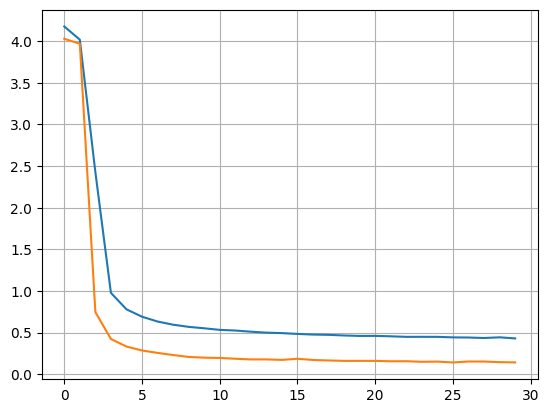

In [4]:
plt.plot(lst_loss_train)
plt.plot(lst_loss_val)
plt.grid()
plt.show()

# Проверка качества модели 

In [3]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds

model_load = nn.DataParallel(MorseNet(num_classes=num_classes))
model_load.load_state_dict(torch.load('MorseNet.pth'))
model_load.eval()

CNN размерность выхода: torch.Size([1, 32, 16, 89])
CNN число фичей: 512
Проекция из 512 в 1024


DataParallel(
  (module): MorseNet(
    (net_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): GELU(approximate='none')
      (7): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): GELU(approximate='none')
      (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(32, 32, kernel_size=(3

In [4]:
with torch.no_grad():
    train_mess = []
    train_predicts = []
    for loader in train_dl:
        seq, test_target, _, mess = loader
        train_mess.extend(mess)

        logits = model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        train_predicts.extend(predicted_values)

    val_mess = []
    val_predicts = []
    for loader in val_dl:
        seq, test_target, _, mess = loader
        val_mess.extend(mess)

        logits= model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        val_predicts.extend(predicted_values)

import Levenshtein

mean_acc_test = np.mean([Levenshtein.ratio(test_pred, train_mess[ind]) for ind, test_pred in enumerate(train_predicts)])
mean_acc_val = np.mean([Levenshtein.ratio(val_pred, val_mess[ind]) for ind, val_pred in enumerate(val_predicts)])


print(f"Mean accurasu by The Levenshtein in train is : {mean_acc_test}")
print(f"Mean accurasu by The Levenshtein in validate is : {mean_acc_val}")

Mean accurasu by The Levenshtein in train is : 0.8396696467581081
Mean accurasu by The Levenshtein in validate is : 0.9091199388053927


In [5]:
test_ds = MosreDataset(df=sample_data,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=False,
                        transforms=valid_audio_transforms)
     
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, shuffle=False, collate_fn=my_collate)
model_load.eval()

with torch.no_grad():
    test_predicts = []
    for loader in test_dl:
        seq = loader
        logits = model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        test_predicts.extend(predicted_values)

sample_data.message = test_predicts
sample_data.to_csv('sample_submission.csv', index=False)